# Network to osmnx network

This experimental notebook has the objective of finding the way to transfer data from lines (e.g. a non-osmnx network) to a osmnx network.
* __Result:__ A __99.8432% success__ was reached in an area with 338 lines and 659 OSMnx edges by using __hausdorff_distance from shapely__.

## Import libraries

In [1]:
accesibilidad_urbana = '../../'

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np

import math

import shapely
from shapely.ops import nearest_points
from shapely.geometry import Point,LineString
from shapely.geometry import GeometryCollection

from shapely import hausdorff_distance, frechet_distance

from shapely.ops import split
import time

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [3]:
# Projection to be used whenever necessary
projected_crs = 'EPSG:32719'

## Strategy 1 - Find nearest point from one gdf to point of another gdf keeping IDs

### Create data

In [53]:
d = {'point_id': ['Juárez', 'Allende','Aldama','Carranza'], 
     'geometry': [Point(21, 2.4), Point(31, 2.4), Point(41, 2.4), Point(51, 2.4)]}
local_network = gpd.GeoDataFrame(d, crs=projected_crs)
local_network

,point_id,geometry
0,Juárez,POINT (21.000 2.400)
1,Allende,POINT (31.000 2.400)
2,Aldama,POINT (41.000 2.400)
3,Carranza,POINT (51.000 2.400)


In [54]:
d = {'street_id': ['osmid1', 'osmid1','osmid1','osmid1','osmid1',
                  'osmid2', 'osmid2','osmid2','osmid2','osmid2'], 
     'geometry': [Point(25,0),Point(35,0),Point(45,0),Point(55,0),Point(65,0),
                 Point(35,-5),Point(35,0),Point(35,5),Point(35,10),Point(35,15)]}
osmnx_network = gpd.GeoDataFrame(d, crs=projected_crs)
osmnx_network

,street_id,geometry
0,osmid1,POINT (25.000 0.000)
1,osmid1,POINT (35.000 0.000)
2,osmid1,POINT (45.000 0.000)
3,osmid1,POINT (55.000 0.000)
4,osmid1,POINT (65.000 0.000)
5,osmid2,POINT (35.000 -5.000)
6,osmid2,POINT (35.000 0.000)
7,osmid2,POINT (35.000 5.000)
8,osmid2,POINT (35.000 10.000)
9,osmid2,POINT (35.000 15.000)


<Axes: >

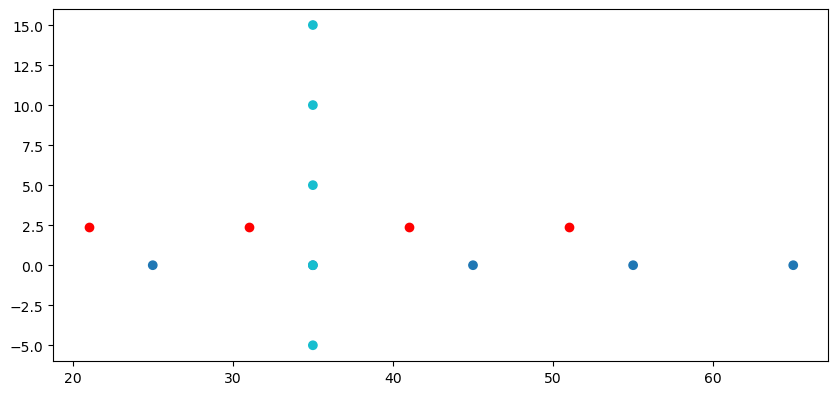

In [55]:
fig,ax = plt.subplots(figsize=(10,10))
local_network.plot(ax=ax,color='red')
osmnx_network.plot('street_id',ax=ax)

In [56]:
# Eliminar duplicados geométricos en ambos gdfs
print(len(local_network))
print(len(osmnx_network))
calles_gdf = local_network.drop_duplicates(subset='geometry')
target_gdf = osmnx_network.drop_duplicates(subset='geometry')
print(len(calles_gdf))
print(len(target_gdf))

4
10
4
9


### Find nearest

In [57]:
# Función para encontrar el punto más cercano de target_gdf para un punto dado
def nearest(row, other_gdf, geom_col='geometry', src_geom_col='geometry'):
    # Encuentra el punto más cercano a 'row' en 'other_gdf'
    nearest_geom = nearest_points(row[geom_col], other_gdf.unary_union)[1]
    # Encuentra la fila completa en 'other_gdf' que tiene esa geometría
    nearest_row = other_gdf.loc[other_gdf[geom_col] == nearest_geom]
    return nearest_row.iloc[0]

# Aplicar la función para encontrar el punto más cercano para cada punto en calles_gdf
nearest_nodes =calles_gdf.apply(nearest, other_gdf=target_gdf, axis=1)
calles_nearest = calles_gdf.copy()
calles_nearest['nearest_st'] = nearest_nodes['street_id']
calles_nearest['nearest_geom'] = nearest_nodes['geometry']

# Calcular la distancia al punto más cercano
calles_nearest['distance_to_nearest'] = calles_nearest.distance(calles_nearest['nearest_geom'])

calles_nearest

,point_id,geometry,nearest_st,nearest_geom,distance_to_nearest
0,Juárez,POINT (21.000 2.400),osmid1,POINT (25.000 0.000),4.664762
1,Allende,POINT (31.000 2.400),osmid1,POINT (35.000 0.000),4.664762
2,Aldama,POINT (41.000 2.400),osmid1,POINT (45.000 0.000),4.664762
3,Carranza,POINT (51.000 2.400),osmid1,POINT (55.000 0.000),4.664762


## Strategy 2 - Most similar geometry to another line (Hausdorff, Frechet)

### __Strategy 2__ - Simple test

In [150]:
d = {'street_id': ['Juárez','Aldama'], 
     'geometry': [LineString([(21, 2.4),(51, 2.4)]),LineString([(30, -5),(30, 15)])]}
local_network = gpd.GeoDataFrame(d, crs=projected_crs)
local_network

,street_id,geometry
0,Juárez,"LINESTRING (21.000 2.400, 51.000 2.400)"
1,Aldama,"LINESTRING (30.000 -5.000, 30.000 15.000)"


In [167]:
d = {'osmid_id': ['osmid3','osmid2','osmid1'], 
     'geometry': [LineString([(20, 2.75),(50, 2.75)]),LineString([(20, 0),(50, 0)]),LineString([(35, -5),(35, 15)])]}
osmnx_network = gpd.GeoDataFrame(d, crs=projected_crs)
osmnx_network

,osmid_id,geometry
0,osmid3,"LINESTRING (20.000 2.750, 50.000 2.750)"
1,osmid2,"LINESTRING (20.000 0.000, 50.000 0.000)"
2,osmid1,"LINESTRING (35.000 -5.000, 35.000 15.000)"


<Axes: >

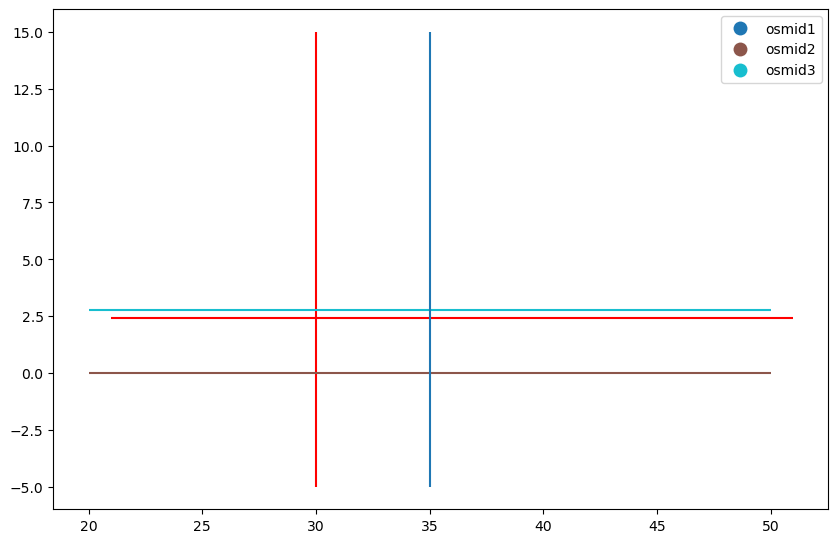

In [180]:
fig,ax = plt.subplots(figsize=(10,10))
local_network.plot(ax=ax,color='red')
osmnx_network.plot('osmid_id',ax=ax,legend=True)

In [177]:
original_network = local_network.copy()
target_network = osmnx_network.copy()



# Crear una función para encontrar la línea más cercana en términos de Hausdorff
def nearest_line(row, other_gdf):
    min_distance = float('inf')
    nearest_line = None
    
    for _, target_row in other_gdf.iterrows():
        print(row['street_id'])
        distance = row['geometry'].hausdorff_distance(target_row['geometry'])
        print(distance)

        # If currently measured distance is less than registered min_distance, register
        if distance < min_distance:
            min_distance = distance
            nearest_line = target_row['osmid_id']
            print(nearest_line)
    
    print(f'Winner:{nearest_line}')
    print('----Next street-----')
    
    return nearest_line

# Aplicar la función para encontrar la línea más cercana para cada línea en original_network
original_network['nearest_line'] = original_network.apply(nearest_line, other_gdf=target_network, axis=1)
original_network

Juárez
1.0594810050208545
osmid3
Juárez
2.6
Juárez
16.0
Winner:osmid3
----Next street-----
Aldama
20.0
osmid3
Aldama
20.0
Aldama
5.0
osmid1
Winner:osmid1
----Next street-----


,street_id,geometry,nearest_line
0,Juárez,"LINESTRING (21.000 2.400, 51.000 2.400)",osmid3
1,Aldama,"LINESTRING (30.000 -5.000, 30.000 15.000)",osmid1


### __Strategy 2__ - Real test

In [4]:
gral_dir = accesibilidad_urbana+"data/external/specific-network_transfer/"
gral_dir

'../../data/external/specific-network_transfer/'

In [45]:
# 1.0 --------------- LOAD DATA
# ------------------- Load local network
# Load data
local_network = gpd.read_file(gral_dir+"test_area_01_local_streets_32719.gpkg")
# Set CRS
if local_network.crs != projected_crs:
    try:
        local_network = local_network.set_crs(projected_crs)
    except:
        local_network = local_network.to_crs(projected_crs)

# Filter data
local_network = local_network[['IDcllbf','pje_ep','geometry']]
local_network.rename(columns={'IDcllbf':'street_id'},inplace=True)

# Show
print(local_network.shape)
local_network.head(2)

(338, 3)


,street_id,pje_ep,geometry
0,150.0,0.261844,"MULTILINESTRING ((336866.602 6296306.973, 3369..."
1,152.0,0.130970,"MULTILINESTRING ((336776.728 6296302.353, 3367..."


In [46]:
local_network.loc[local_network.street_id.isin(st_list)]

,street_id,pje_ep,geometry
29,5816.0,0.561362,"MULTILINESTRING ((336628.836 6296436.203, 3366..."
30,5816.0,0.561362,"MULTILINESTRING ((336647.921 6296432.195, 3366..."
329,31424.0,0.385330,"MULTILINESTRING ((336404.763 6296483.306, 3364..."
330,31424.0,0.385330,"MULTILINESTRING ((336625.589 6296436.870, 3366..."


In [6]:
# 1.0 --------------- LOAD DATA
# ------------------- Load OSMnx network
# Load data
osmnx_network = gpd.read_file(gral_dir+"test_area_01_osmnx_edges_32719.gpkg")
# Set CRS
if osmnx_network.crs != projected_crs:
    try:
        osmnx_network = osmnx_network.set_crs(projected_crs)
    except:
        osmnx_network = osmnx_network.to_crs(projected_crs)

# Show
print(osmnx_network.shape)
osmnx_network.head(2)

(659, 18)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,443198326,443198676,0,484811205,False,2,Isla Grande de Tierra del Fuego,tertiary,None,146.940,None,None,None,None,None,None,None,"MULTILINESTRING ((336391.411 6296634.969, 3363..."
1,443198341,9102377120,0,213285792,True,2,Avenida La Laguna Sur,secondary,None,101.142,None,None,None,None,None,None,None,"MULTILINESTRING ((336398.321 6296484.718, 3364..."


### Approach 1: Function applied to local_network

In [11]:
# Create unique ID for each OSMnx edge using u and v
target_network = osmnx_network.copy()
target_network['u'] = target_network['u'].astype('str')
target_network['v'] = target_network['v'] .astype('str')
target_network['osmnx_id']= target_network['u']+ target_network['v']

# Copy local network
original_network = local_network.copy()

# Find nearest line to each line using Hausdorff distance
def nearest_line(row, other_gdf):
    # For each row(line), set min_distance found to infinite
    min_distance = float('inf')
    nearest_line = None

    # For each row(line) in the target_gdf (OSMnx network), iterate and find distance to current line
    for _, target_row in other_gdf.iterrows():
        distance = row['geometry'].hausdorff_distance(target_row['geometry'])

        # If currently measured distance is less than registered min_distance, rewrite min_distance and nearest_line
        if distance < min_distance:
            min_distance = distance
            nearest_line = target_row['osmnx_id']
            #print(f"Found closer line for idx {row['street_id']} at distance {distance}. Close line: {nearest_line}")

    # Finally, register result
    row['nearest_line'] = nearest_line
    row['min_distance'] = min_distance
    
    return row

# Apply nearest_line() function to find closest line to each line in original network
#original_network['nearest_line'], original_network['min_distance'] = original_network.apply(nearest_line, other_gdf=target_network, axis=1)
original_network = original_network.apply(nearest_line, other_gdf=target_network, axis=1)

# Show
print(original_network.shape)
original_network.head(1)

(338, 5)


,street_id,pje_ep,geometry,nearest_line,min_distance
0,150.0,0.261844,"MULTILINESTRING ((336866.602 6296306.973, 3369...",443960579443960768,3.154251


In [265]:
# Find duplicated nearest lines (Occurs when two or more original network lines get assigned to the same OSMnx network line)
duplicated_nearest_lines = original_network.loc[original_network.duplicated(subset='nearest_line', keep=False)]
# For each duplicated nearest line, keep the row with the lowest 'min_distance' (The most similar according to hausdorff_distance result)
idx_min = duplicated_nearest_lines.groupby('nearest_line')['min_distance'].idxmin()
# Filter selected rows
filtered_duplicates = duplicated_nearest_lines.loc[idx_min]

# Remove those duplicated lines from the resulting network
filtered_network = original_network.copy()
filtered_network = filtered_network.drop_duplicates(subset='nearest_line',keep=False)
# Append filtered duplicates
filtered_network = pd.concat([filtered_network,filtered_duplicates])

# Show
print(f"Uniquely assigned OSMnx lines to original lines gdf: {len(resulting_network.nearest_line.unique())}.")
print(filtered_network.shape)
filtered_network.head(1)

Uniquely assigned OSMnx lines to original lines gdf: 301.
(301, 5)


,street_id,pje_ep,geometry,nearest_line,min_distance
0,150.0,0.261844,"MULTILINESTRING ((336866.602 6296306.973, 3369...",443960579443960768,3.154251


In [266]:
# CHECK RESULT IN QGIS
duplicated_nearest_lines.to_file(gral_dir + "duplicated_nearest_lines.gpkg", driver='GPKG')
filtered_network.to_file(gral_dir + "filtered_network.gpkg", driver='GPKG')

In [267]:
# Merge street_id and columns of interest back to osmnx network
resulting_network = pd.merge(target_network,filtered_network[['street_id','pje_ep','nearest_line']],
                             left_on='osmnx_id',right_on='nearest_line')
resulting_network.drop(columns=['nearest_line'],inplace=True)

# Show
print(resulting_network.shape)
resulting_network.head(1)

(301, 21)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,...,ref,junction,tunnel,access,width,service,geometry,osmnx_id,street_id,pje_ep
0,443198326,443198676,0,484811205,False,2,Isla Grande de Tierra del Fuego,tertiary,None,146.94,...,None,None,None,None,None,None,"MULTILINESTRING ((336402.936 6296515.282, 3364...",443198326443198676,19412.0,0.873692


In [268]:
resulting_network.to_file(gral_dir + "resulting_network_filtered.gpkg", driver='GPKG')

In [ ]:
# Problema de duplicados en la original network:
# Ocurre cuando una línea de la red original tiene como correspondiente dos (o más) líneas más pequeñas de OSMnx.
# Hausdorff, en lugar de asignarle una de las dos (o más) líneas, asigna la paralela más cercana. Esa paralela, aparte tendrá su línea original correspondiente.
# Posible solución: Antes de asignar la línea a la row, guardar en un gdf la línea original, la distancia Hausdorff y el osmnx_id que se está guardando.
# Para las siguientes líneas, si una línea se quiere asignar a un osmnx_id que ya está guardado, buscar la línea original que se había guardado y comparar las distancias Hausdorff.
# Mantener la conección para la distancia Hausdorff que sea menor y guardar en una lista la línea original cuya asignación fue errónea.
# La función deberá regresar esa lista y se deberá repetir el proceso retirando de la red de OSMnx las líneas ya asignadas.

# Problema de 

### Approach 2: Function applied to osmnx_network.

In [7]:
def get_multiline_angle(row):
    # Get geometry
    multi_line = row.geometry
    
    # Get the first LineString in the MultiLineString
    first_line = multi_line.geoms[0]
    # Get the last LineString in the MultiLineString
    last_line = multi_line.geoms[-1]
    
    # Get the starting point (first coordinate of the first LineString)
    start_point = first_line.coords[0]
    # Get the ending point (last coordinate of the last LineString)
    end_point = last_line.coords[-1]
    
    # Calculate the differences in coordinates
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    # Calculate the angle in radians
    angle_radians = math.atan2(dy, dx)
    # Convert the angle to degrees
    angle_degrees = math.degrees(angle_radians)
    # If angle is negative, make positive
    if angle_degrees < 0:
        angle_degrees += 360
        
    # Change angle to 0° to 180° format
    if angle_degrees > 180:
        angle_reversed = angle_degrees - 180
        row['line_angle'] = angle_reversed
    else:
        row['line_angle'] = angle_degrees

    return row

In [131]:
# Create unique ID for each OSMnx edge using u and v
target_network = osmnx_network.copy()
target_network['u'] = target_network['u'].astype('str')
target_network['v'] = target_network['v'] .astype('str')
target_network['osmnx_id']= target_network['u']+ target_network['v']

# Copy local network
original_network = local_network.copy()

############ ANGLE CONSIDERATION
# Get OSMnx network lines angle
target_network = target_network.apply(get_multiline_angle,axis=1)
# Get local network lines angle
original_network = original_network.apply(get_multiline_angle,axis=1)
############ ANGLE CONSIDERATION

##### Tests
#st_list = [31424,5816]
#target_network = target_network.loc[target_network.osmnx_id=='443887978443887980']
#original_network = original_network.loc[original_network.street_id.isin(st_list)]
##### Tests

def find_best_line(row_line, line_1, line_2, buff_dist):

    # Create buffer around row_line and candidate lines with buffer distance
    row_line_buffer = row_line.buffer(buff_dist)
    line_1_buffer = line_1.buffer(buff_dist)
    line_2_buffer = line_2.buffer(buff_dist)

    # Find which is the shortest line
    row_line_length = row_line.length
    #print(f"row_lenght: {row_line_length}.")
    line_1_length = line_1.length
    #print(f"line_1_length: {line_1_length}.")
    line_2_length = line_2.length
    #print(f"line_2_length: {line_2_length}.")

    # Calculate percentage of overlapping in shortest line between row_line and line_1
    if row_line_length < line_1_length:
        line_1_overlaping_area_pct = (row_line_buffer.intersection(line_1_buffer).area) / (row_line_buffer.area)
    else:
        line_1_overlaping_area_pct = (line_1_buffer.intersection(row_line_buffer).area) / (line_1_buffer.area)
    
    # Calculate percentage of overlapping in shortest line between row_line and line_2
    if row_line_length < line_2_length:
        line_2_overlaping_area_pct = (row_line_buffer.intersection(line_2_buffer).area) / (row_line_buffer.area)
    else:
        line_2_overlaping_area_pct = (line_2_buffer.intersection(row_line_buffer).area) / (line_2_buffer.area)

    # Choose the line which creates a bigger overlap
    print(f"line_1_overlaping_area_pct: {line_1_overlaping_area_pct}.")
    print(f"line_2_overlaping_area_pct: {line_2_overlaping_area_pct}.")
    if line_1_overlaping_area_pct > line_2_overlaping_area_pct:
        best_row = '1'
    else:
        best_row = '2'

    return best_row

# Find nearest line to each line using Hausdorff distance
def nearest_line(row, other_gdf, adjacent=True, angle_consideration=(False,0),buffer_consideration=(False,0)):
    #print(row['osmnx_id'])
    # For each row(line), set min_distance found to infinite
    best_distance = float('inf')
    # For each row, nearest line hasn't been found yet
    nearest_line = None

    # Clip other_gdf network to lines adjacent to lines of interest
    if adjacent:
        # Select adjacent lines to row (Lines of interest)
        line_buffer = row['geometry'].buffer(10)
        adjacent_lines = other_gdf.clip(line_buffer)
        adjacent_lines = adjacent_lines.to_crs(projected_crs)
        
         # Prevent crash
        if len(adjacent_lines) == 0:
            print(f"Found no adjacent lines for {row['osmnx_id']}.")
            return row
    else:
        # Consider full network
        adjacent_lines = other_gdf.copy()
    
    # For each row(line) in the other_gdf (original_network):
    candidate_i = 0
    for _, target_row in adjacent_lines.iterrows():
        # Find distance to current line
        distance = row['geometry'].hausdorff_distance(target_row['geometry'])

        if angle_consideration[0]:
            # Consider absolute difference in direction of both lines 
            angle_diff = abs(row['line_angle'] - target_row['line_angle'])
            # If currently measured distance is less than registered best_distance AND the angle does not exceed the consideration, rewrite best_distance and nearest_line
            if (distance < best_distance) and (angle_diff < angle_consideration[1]):
                if candidate_i==0:
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = target_row['street_id']
                    best_line = target_row['geometry']
                else:
                    # Save second best (previous best)
                    second_best_distance = best_distance
                    second_best_nearest = best_nearest
                    second_best_line = best_line
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = target_row['street_id']
                    best_line = target_row['geometry']

                candidate_i+=1
                
                #nearest_line = target_row['street_id']
                #print(f"Found closer line for idx {row['street_id']} at distance {distance}. Close line: {nearest_line}")
        else:
            # Do not consider angle (If currently measured distance is less than registered best_distance, rewrite best_distance and nearest_line
            if distance < best_distance:
                if candidate_i==0:
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = target_row['street_id']
                    best_line = target_row['geometry']
                else:
                    # Save second best (previous best)
                    second_best_distance = best_distance
                    second_best_nearest = best_nearest
                    second_best_line = best_line
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = target_row['street_id']
                    best_line = target_row['geometry']
                
                candidate_i+=1

                #nearest_line = target_row['street_id']
                #print(f"Found closer line for idx {row['street_id']} at distance {distance}. Close line: {nearest_line}")

    if candidate_i == 0:
        print(f"Found no similar line for {row['osmnx_id']}.")
        return row
    
    # Finally, register result
    if (buffer_consideration[0]) and (best_distance>buffer_consideration[1]):
        
        # Apply function that identifies best line according to pct of overlap of buffers
        row_line = row['geometry']
        buff_dist = buffer_consideration[1]
        best_row = find_best_line(row_line, best_line, second_best_line, buff_dist)
        
        # Register result
        if best_row == '1':
            row['nearest_line'] = best_nearest
            row['min_distance'] = best_distance
            row['buff_consid'] = 1
            print(f"Chose line closest distance line {best_nearest} over line {second_best_nearest} for row {row['osmnx_id']}.")
        else:
            row['nearest_line'] = second_best_nearest
            row['min_distance'] = second_best_distance
            row['buff_consid'] = 1
            print(f"Chose line farthest distance line {second_best_nearest} over line {best_nearest} for row {row['osmnx_id']}.")
    
    else:
        row['nearest_line'] = best_nearest
        row['min_distance'] = best_distance
        row['buff_consid'] = 0

    return row

# Apply nearest_line() function to find closest line to each line in OSMnx network
target_network = target_network.apply(nearest_line, other_gdf=original_network, adjacent=True, angle_consideration=(True,45), buffer_consideration=(False,30), axis=1)

# Show
print(target_network.shape)
target_network.head(1)

Found no adjacent lines for 12786789751278679063.
Found no adjacent lines for 12786789811278678994.
Found no adjacent lines for 12786789941278678981.
Found no adjacent lines for 12786790631278679189.
Found no adjacent lines for 12786791891278679063.
Found no similar line for 44584806079203890370.
Found no similar line for 91022861149102286115.
Found no similar line for 91022861159102286114.
Found no similar line for 91022861169102377117.
Found no similar line for 91023771179102286116.
Found no similar line for 91023771229102377123.
Found no similar line for 91023771239102377122.
Found no similar line for 91023771289102377129.
Found no similar line for 91023771299102377128.
Found no adjacent lines for 92038903699203890370.
Found no similar line for 92038903704458480607.
Found no adjacent lines for 92038903709203890369.
Found no adjacent lines for 92038903709203890371.
Found no adjacent lines for 92038903719203890370.
Found no similar line for 92067264989206726499.
Found no similar line 

,access,bridge,buff_consid,geometry,highway,junction,key,lanes,length,line_angle,...,nearest_line,oneway,osmid,osmnx_id,ref,service,tunnel,u,v,width
0,None,None,0.0,"MULTILINESTRING ((336391.411 6296634.969, 3363...",tertiary,None,0,2,146.94,93.790664,...,19412.0,False,484811205,443198326443198676,None,None,None,443198326,443198676,None


In [132]:
# Merge street_id and columns of interest back to osmnx network
resulting_network = pd.merge(target_network,original_network[['street_id','pje_ep']],
                             left_on='nearest_line',right_on='street_id')
resulting_network.drop(columns=['nearest_line'],inplace=True)
resulting_network = resulting_network.drop_duplicates()

# Show
print(resulting_network.shape)
resulting_network.head(1)

(638, 24)


,access,bridge,buff_consid,geometry,highway,junction,key,lanes,length,line_angle,...,osmid,osmnx_id,ref,service,tunnel,u,v,width,street_id,pje_ep
0,None,None,0.0,"MULTILINESTRING ((336391.411 6296634.969, 3363...",tertiary,None,0,2,146.94,93.790664,...,484811205,443198326443198676,None,None,None,443198326,443198676,None,19412.0,0.873692


In [72]:
#resulting_network.to_file(gral_dir + "area01_resulting_network_reversed.gpkg", driver='GPKG')

In [27]:
expected_result = {'1278679194443198341':0.359738694742183,
                   '71559503527155950351':np.nan, #Middle road no equivalent
                   '71559503517155950352':np.nan, #Middle road no equivalent
                   '443198676443198688':0.213769264920403,
                   '443198676443198326':0.873691888120759,
                   '443198326443198676':0.873691888120759,
                   '443960709443198676':0.567641276082958,
                   '7155950351443198676':0.873691888120759,
                   '4431986767155950351':0.873691888120759,
                   '10825092657155950351':np.nan, #Middle road no equivalent
                   '71559503511082509265':np.nan, #Middle road no equivalent
                   '7155950351443198341':0.293619585209615,
                   '4431983417155950351':0.293619585209615,
                   '4431983419102377120':0.385330119870616,
                   '4458480607443198341':0.293619585209615,
                   '4431983414458480607':0.293619585209615,
                   '443960709443960895':0.416788228578677,
                   '443960895443960709':0.416788228578677,
                   '443960677443199182':0.603761019851589,
                   '443199182443960677':0.603761019851589,
                   '443199182443960709':0.387930487727532,
                   '443960706443199182':0.159224963531426,
                   '443960706443960883':0.729403183865035,
                   '443960883443960706':0.729403183865035,
                   '443960704443960706':0.615811505042177,
                   '4439607047990684469':0.714688907211264,
                   '7990684469443960704':0.714688907211264,
                   '443960702443960704':0.689541447326695,
                   '443960852443960702':0.326155895224202,
                   '443960702443960852':0.326155895224202,
                   '443960700443960702':0.728483541574174,
                   '443960850443960700':0.273546013826346,
                   '443960700443960850':0.273546013826346,
                   '443199181443960700':0.401978816515507,
                   '443199181443960600':0.201084543667153,
                   '443960600443199181':0.201084543667153,
                   '91023771209102377122':0.385330119870616,
                   '91023771229102377124':0.385330119870616,
                   '91023771249102377126':0.385330119870616,
                   '91023771269102377128':0.385330119870616,
                   '91023771289102286112':0.385330119870616,
                   '91022861129102286114':0.385330119870616,
                   '9102286114443199177':0.385330119870616,
                   '443199177443888013':0.561362339062599,
                   '443888013443888015':0.616382317498573,
                   '443888015443888017':0.617397095198833,
                   '443888017443888018':0.658876133696962,
                   '4431991811082509265':0.201084543667153,
                   '1082509265443199181':0.201084543667153,
                   '4438880181082509265':0.132999302340331,
                   '1082509265443888018':0.132999302340331,
                   '443960698443199181':0.267933024671783,
                   '52620540011082509265':np.nan, #Middle road no equivalent
                   '10825092655262054001':np.nan, #Middle road no equivalent
                   '443888018443960729':0.195756960740788,
                   '443960842443960698':0.192554068624342,
                   '443960698443960842':0.192554068624342,
                   '2230155857443960698':0.157512526162238,
                   '2230155857605137130':0.54544301388977,
                   '6051371302230155857':0.54544301388977,
                   '22301558632230155857':0.230322826155895,
                   '2230155863605137137':0.435910445867952,
                   '6051371372230155863':0.435910445867952,
                   '4438879982230155863':0.139056256738758,
                   '443888064443887998':0.291177776368364,
                   '443887998443888064':0.291177776368364,
                   '5262054000443887998':0.348227310204858,
                   '4438879965262054000':0.348227310204858,
                   '443888066443887996':0.437908289465339,
                   '443887994443887996':0.348227310204858,
                   '4438879961082509311':0.437908289465339,
                   '1082509311443888021':0.437908289465339,
                   '10825091621082509311':np.nan, #Middle road no equivalent
                   '10825093111082509162':np.nan, #Middle road no equivalent
                   '443888021443888023':0.204350859389865,
                   '443960737443888021':0.204350859389865,
                   '5262054002443960737':0.487251855140483,
                   '52620540015262054000':np.nan, #Pedestrian crossing?
                   '52620540005262054001':np.nan, #Pedestrian crossing?
                   '52620540025262054001':np.nan, #Pedestrian crossing?
                   '52620540015262054002':np.nan, #Pedestrian crossing?
                   '4439607345262054002':0.487251855140483,
                   '443888020443960734':0.15408765142386,
                   '443960731443888020':0.321335701147967,
                   '443960729443960731':0.272689795141752,
                   '52620540011082509311':np.nan, #Middle road no equivalent
                   '10825093115262054001':np.nan, #Middle road no equivalent
                   '443888021443960616':0.426936005581277,
                   '443960616443888121':0.434419991120695,
                   '443888121443888122':0.271199340394495,
                   '443888122443888121':0.271199340394495,
                   '443888121443960614':0.509925794380669,
                   '4439606149206726499':0.199181835479165,
                   '92067264989206726499':np.nan, #Pedestrian crossing?
                   '92067264999206726498':np.nan, #Pedestrian crossing?
                   '9206726499443960611':0.199181835479165,
                   '443960611443888603':0.129384156783155,
                   '4438886032158540083':np.nan, #Pedestrian crossing?
                   '443888603443888598':0.433532060632968,
                   '443888598443990223':0.524925477262637,
                   '443990223443888102':0.417707870869538,
                   '443990223605136908':0.128147396460963,
                   '605136908443990223':0.128147396460963,
                   '605136924605136908':0.210122407560094,
                   '605136908605136924':0.210122407560094,
                   '605136924605136910':0.128654785311093,
                   '605136910605136924':0.128654785311093,
                   '4775632027605136910':0.446565611720682,
                   '6051369104775632027':0.446565611720682,
                   '605136928605136910':0.109722838840616,
                   '605136910605136928':0.109722838840616,
                   '605136928443990414':0.102777953954462,
                   '443990414605136928':0.102777953954462,
                   '443990414443990326':0.230639944187226,
                   '443990326443990414':0.230639944187226,
                   '4458326346443990414':0.119680345024418,
                   '4439904144458326346':0.119680345024418,
                   '44583263454458326346':0.604395255914251,
                   '44583263464458326345':0.604395255914251,
                   '44583263464458326348':0.117048265364369,
                   '44583263484458326346':0.117048265364369,
                   '44583263474458326348':0.325838777192871,
                   '44583263484458326347':0.325838777192871,
                   '6051369824458326348':0.085336462231242,
                   '4458326348605136982':0.085336462231242,
                   '605136982605136916':0.331071224709837,
                   '605136916605136982':0.331071224709837,
                   '605136982447547207':0.093264413014524,
                   '447547207605136982':0.093264413014524,
                   '447547208447547207':0.094152343502252,
                   '447547207447547208':0.094152343502252,
                   '447547207443888285':0.320225788038308,
                   '443888285447547207':0.320225788038308,
                   '443888285443888101':0.296981036341726,
                   '443888101443888285':0.296981036341726,
                   '443888285443889256':0.404198642734826,
                   '443889256443888285':0.404198642734826,
                   '443889237443889256':0.098274877909558,
                   '443889256443889237':0.098274877909558,
                   '443889237443887986':0.113052578169595,
                   '443887986443889237':0.113052578169595,
                   '7993681781443887986':np.nan, #School?
                   '4438879867993681781':np.nan, #School?
                   '1278678993443887986':0.026542779222427,
                   '4438879861278678993':0.026542779222427,
                   '12786789641278678993':0.026542779222427,
                   '12786789931278678964':0.026542779222427,
                   '12786791811278678964':0.026542779222427,
                   '12786789641278679181':0.026542779222427,
                   '12786790541278679181':0.026542779222427,
                   '12786791811278679054':0.026542779222427,
                   '12786791601278679054':0.026542779222427,
                   '12786790541278679160':0.026542779222427,
                   '53752012521278679160':np.nan, #No aplica, fuera de buffer
                   '12786791605375201252':np.nan, #No aplica, fuera de buffer
                   '6250524725375201252':np.nan, #No aplica, fuera de buffer
                   '5375201252625052472':np.nan, #No aplica, fuera de buffer
                   '53752012529206726495':np.nan, #No aplica, fuera de buffer
                   '92067264955375201252':np.nan, #No aplica, fuera de buffer
                   '12786789465375201252':np.nan, #No aplica, fuera de buffer
                   '53752012521278678946':np.nan, #No aplica, fuera de buffer
                   '12786789461278679191':np.nan, #No aplica, fuera de buffer
                   '12786791911278678946':np.nan, #No aplica, fuera de buffer
                   '12786789191278678946':np.nan, #No aplica, fuera de buffer
                   '12786789461278678919':np.nan, #No aplica, fuera de buffer
                   '12786789191278678992':np.nan, #No aplica, fuera de buffer
                   '12786789921278678919':np.nan, #No aplica, fuera de buffer
                   '9723822721278678919':np.nan, #No aplica, fuera de buffer
                   '1278678919972382272':np.nan, #No aplica, fuera de buffer
                   '9723822721278679157':np.nan, #No aplica, fuera de buffer
                   '1278679157972382272':np.nan, #No aplica, fuera de buffer
                   '9723822721861191897':np.nan, #No aplica, fuera de buffer
                   '1861191897972382272':np.nan, #No aplica, fuera de buffer
                   '12786789751861191897':np.nan, #No aplica, fuera de buffer
                   '18611918971278678975':np.nan, #No aplica, fuera de buffer
                   '12786789371861191897':np.nan, #No aplica, fuera de buffer
                   '18611918971278678937':np.nan, #No aplica, fuera de buffer
                   '1278678937443199195':0.058032599733621,
                   '4431991951278678937':0.058032599733621,
                   '1278679063443199195':0.455254645779159,
                   '4431991951278679063':0.455254645779159,
                   '4458480607443199195':0.293619585209615,
                   '4431991954458480607':0.293619585209615,
                   '92038903704458480607':np.nan, #Entrada conjunto habitacional?
                   '44584806079203890370':np.nan, #Entrada conjunto habitacional?
                   '443960729443960668':0.156973425508974,
                   '443960668443960729':0.156973425508974,
                   '443960649443960668':0.190524513223822,
                   '443960668443960649':0.190524513223822,
                   '443960765443960731':0.178949705080231,
                   '443960731443960765':0.178949705080231,
                   '443960768443960765':0.182152597196677,
                   '443960765443960768':0.182152597196677,
                   '443960670443960768':0.155926936005581,
                   '443960768443960670':0.155926936005581,
                   '443960670443960771':0.15874928648443,
                   '443960771443960670':0.15874928648443,
                   '443960651443960771':0.161381366144479,
                   '443960771443960651':0.161381366144479,
                   '443888020443960576':0.1072176063931,
                   '443960576443888020':0.1072176063931,
                   '443960576443960579':0.110325363100146,
                   '443960579443960576':0.110325363100146,
                   '443960579443960582':0.086097545506438,
                   '443960582443960579':0.086097545506438,
                   '443960582443888119':0.330880953891038,
                   '443888119443960582':0.330880953891038,
                   '60863810756086381076':0.35311092788736,
                   '60863810766086381075':0.35311092788736,
                   '60862259116086225912':0.268155007293715,
                   '60862259126086225911':0.268155007293715,
                   '443960734443960786':0.212342233779413,
                   '443960786443960734':0.212342233779413,
                   '443960777443960786':0.315247034946407,
                   '443960786443960777':0.315247034946407,
                   '4439607774775632036':0.19851588761337,
                   '4775632036443960777':0.19851588761337,
                   '4439607834775632036':0.186053148982051,
                   '4775632036443960783':0.186053148982051,
                   '443960658443960783':0.150694488488615,
                   '443960783443960658':0.150694488488615,
                   '443960737443960820':0.208187987568973,
                   '443960820443960737':0.208187987568973,
                   '443960660443960820':0.181803767362212,
                   '443960820443960660':0.181803767362212,
                   '443960668443888230':0.130969746939811,
                   '443888230443960668':0.130969746939811,
                   '443960668443960670':0.156085495021247,
                   '443960670443960668':0.156085495021247,
                   '443960576443960765':0.303450244180884,
                   '443960765443960576':0.303450244180884,
                   '443960768443960579':0.261844358470223,
                   '443960579443960768':0.261844358470223,
                   '4439607716086381076':0.340140800405911,
                   '6086381076443960771':0.340140800405911,
                   '4439605826086381076':0.507452273736285,
                   '6086381076443960582':0.507452273736285,
                   '443960576443960786':0.299295997970445,
                   '443960786443960576':0.299295997970445,
                   '443960579443960777':0.187511891926175,
                   '443960777443960579':0.187511891926175,
                   '4439605826086225911':0.254296949324539,
                   '6086225911443960582':0.254296949324539,
                   '4439607836086225911':0.194678759434261,
                   '6086225911443960783':0.194678759434261,
                   '4439608204775632036':0.1938542525528,
                   '4775632036443960820':0.1938542525528,
                   '443960616443960820':0.444726327138961,
                   '443960820443960616':0.444726327138961,
                   '443960649443888116':0.119236379780554,
                   '443888116443960649':0.119236379780554,
                   '443960649443960651':0.191602714530348,
                   '443960651443960649':0.191602714530348,
                   '443960651443888117':[0.191602714530348,0.361577979323904], #Different geometrical join at node, could get any value
                   '443888117443960651':[0.191602714530348,0.361577979323904], #Different geometrical join at node, could get any value
                   '4438881176086381075':0.361577979323904,
                   '6086381075443888117':0.361577979323904,
                   '4438881186086381075':[0.361577979323904,0.512050485190588], #Different geometrical join at node, could get any value
                   '6086381075443888118':[0.361577979323904,0.512050485190588], #Different geometrical join at node, could get any value
                   '443888119443888118':0.512050485190588,
                   '443888118443888119':0.512050485190588,
                   '443960654443888119':0.209583306906831,
                   '443888119443960654':0.209583306906831,
                   '4439606546086225912':[0.209583306906831,0.278651614130779], #Different geometrical join at node, could get any value
                   '6086225912443960654':[0.209583306906831,0.278651614130779], #Different geometrical join at node, could get any value
                   '4439606566086225912':0.278651614130779,
                   '6086225912443960656':0.278651614130779,
                   '443960656443960658':[0.278651614130779,0.189319464704763], #Different geometrical join at node, could get any value
                   '443960658443960656':[0.278651614130779,0.189319464704763], #Different geometrical join at node, could get any value
                   '443960658443960660':0.189319464704763,
                   '443960660443960658':0.189319464704763,
                   '443888121443960660':0.271199340394495,
                   '443960660443888121':0.271199340394495,
                   '443889363443888238':0.18158178474028,
                   '443888238443889363':0.18158178474028,
                   '443960614443960802':0.143876450814993,
                   '443960802443960614':0.143876450814993,
                   '443889016443888243':0.176983573285977,
                   '443888243443889016':0.176983573285977,
                   '443960611443960804':0.143495909177396,
                   '443960804443960611':0.143495909177396,
                   '443888947443888248':0.097799200862561,
                   '443888248443888947':0.097799200862561,
                   '4438889471860726180':0.190429377814423,
                   '1860726180443888947':0.190429377814423,
                   '4438889361860726180':[0.190429377814423,0.221538656688019], #Different geometrical join at node, could get any value
                   '1860726180443888936':[0.190429377814423,0.221538656688019], #Different geometrical join at node, could get any value
                   '443888929443888936':0.221538656688019,
                   '443888936443888929':0.221538656688019,
                   '443888912443888929':0.238885013001839,
                   '443888929443888912':0.238885013001839,
                   '443960635443888912':0.105124627386313,
                   '443888912443960635':0.105124627386313,
                   '443960635443960632':0.100938669372741,
                   '443960632443960635':0.100938669372741,
                   '4439606324775632028':[0.100938669372741,0.075442379653707], #Different geometrical join at node, could get any value
                   '4775632028443960632':[0.100938669372741,0.075442379653707], #Different geometrical join at node, could get any value
                   '47756320287993771523':0.075442379653707,
                   '79937715234775632028':0.075442379653707,
                   '4438886037993771523':0.132460201687068,
                   '7993771523443888603':0.132460201687068,
                   '47756320304775632031':0.169087334305829,
                   '47756320314775632030':0.169087334305829,
                   '47756320294775632030':0.185514048328788,
                   '47756320304775632029':0.185514048328788,
                   '47756320344775632035':0.204192300374199,
                   '47756320354775632034':0.204192300374199,
                   '47756320334775632034':0.28616731147333,
                   '47756320344775632033':0.28616731147333,
                   '513707172443888876':0.084067990105917,
                   '443888876513707172':0.084067990105917,
                   '605136980443888876':0.164140293017061,
                   '443888876605136980':0.164140293017061,
                   '6051369804458326350':0.206665821018583,
                   '4458326350605136980':0.206665821018583,
                   '44583263494458326350':0.205777890530856,
                   '44583263504458326349':0.205777890530856,
                   '4458326349443888873':0.174161222807129,
                   '4438888734458326349':0.174161222807129,
                   '605137027443888873':0.543667152914315,
                   '443888873605137027':0.543667152914315,
                   '605137027605137028':0.187543603729308,
                   '605137028605137027':0.187543603729308,
                   '605137011605137028':0.169182469715228,
                   '605137028605137011':0.169182469715228,
                   '443888598605137011':0.171465719540813,
                   '605137011443888598':0.171465719540813,
                   '9130756763443888947':0.245766474281728,
                   '4438889479130756763':0.245766474281728,
                   '9130756762443888876':0.245766474281728,
                   '4438888769130756762':0.245766474281728,
                   '447547207443888876':0.167248049724107,
                   '443888876447547207':0.167248049724107,
                   '47756320311860726180':0.219984778334496,
                   '18607261804775632031':0.219984778334496,
                   '47756320314775632035':0.203050675461407,
                   '47756320354775632031':0.203050675461407,
                   '6051369804775632035':0.18979514175176,
                   '4775632035605136980':0.18979514175176,
                   '605136980605136982':0.183769899156466,
                   '605136982605136980':0.183769899156466,
                   '443889363443888117':0.129732986617619,
                   '443888117443889363':0.129732986617619,
                   '443889016443889363':0.21789179932771,
                   '443889363443889016':0.21789179932771,
                   '443888936443889016':0.220967844231623,
                   '443889016443888936':0.220967844231623,
                   '44583263484458326350':0.212469080991945,
                   '44583263504458326348':0.212469080991945,
                   '443888929443888118':0.176190778207649,
                   '443888118443888929':0.176190778207649,
                   '44583263464458326349':0.227215069448849,
                   '44583263494458326346':0.227215069448849,
                   '443888912443888119':0.12659351810744,
                   '443888119443888912':0.12659351810744,
                   '4775632030443888912':0.186465402422782,
                   '4438889124775632030':0.186465402422782,
                   '47756320304775632034':0.279412697405975,
                   '47756320344775632030':0.279412697405975,
                   '4775632034443888873':0.229847149108898,
                   '4438888734775632034':0.229847149108898,
                   '9069345081443888873':0.529333417898142,
                   '4438888739069345081':0.529333417898142,
                   '9069345081443990414':0.098718843153422,
                   '4439904149069345081':0.098718843153422,
                   '443960635443960654':0.096245322509038,
                   '443960654443960635':0.096245322509038,
                   '6051370279069345082':0.719065136043635,
                   '9069345082605137027':0.719065136043635,
                   '9069345082605136928':0.182469715228008,
                   '6051369289069345082':0.182469715228008,
                   '443960656443960802':0.1581467622249,
                   '443960802443960656':0.1581467622249,
                   '443960802443960804':0.144225280649458,
                   '443960804443960802':0.144225280649458,
                   '443960632443960804':0.074713008181645,
                   '443960804443960632':0.074713008181645,
                   '47756320284775632029':0.104300120504852,
                   '47756320294775632028':0.104300120504852,
                   '47756320294775632033':0.262795712564216,
                   '47756320334775632029':0.262795712564216,
                   '6051370284775632033':0.191539290924082,
                   '4775632033605137028':0.191539290924082,
                   '605137028605136924':0.188019280776305,
                   '605136924605137028':0.188019280776305,
                   '79937715227993771523':0.193632269930868,
                   '79937715237993771522':0.193632269930868,
                   '6051370117993771525':0.193632269930868,
                   '7993771525605137011':0.193632269930868,
                   '605136908605137011':0.197215703684912,
                   '605137011605136908':0.197215703684912,
                   '12786789511861191897':0.020200418595801,
                   '18611918971278678951':0.020200418595801,
                   '12786789511278679185':0.020200418595801,
                   '12786791851278678951':0.020200418595801,
                   '12786791761278679185':0.020200418595801,
                   '12786791851278679176':0.020200418595801,
                   '12786791341278679176':0.020200418595801,
                   '12786791761278679134':0.020200418595801,
                   '12786789741278679134':[0.020200418595801,0.020200418595801], #Different geometrical join at node, could get any value
                   '12786791341278678974':[0.020200418595801,0.020200418595801], #Different geometrical join at node, could get any value
                   '12786789741278679005':0.020200418595801,
                   '12786790051278678974':0.020200418595801,
                   '12786790051278679065':0.020200418595801,
                   '12786790651278679005':0.020200418595801,
                   '12786789531278679065':0.020200418595801,
                   '12786790651278678953':0.020200418595801,
                   '12786789531278679136':0.020200418595801,
                   '12786791361278678953':0.020200418595801,
                   '12786789671278679136':0.020200418595801,
                   '12786791361278678967':0.020200418595801,
                   '4438879801278678967':0.042208409970191,
                   '1278678967443887980':0.042208409970191,
                   '443888772443887980':0.226073444536056,
                   '443887980443888772':0.226073444536056,
                   '443888772443888954':0.199879495148094,
                   '443888954443888772':0.199879495148094,
                   '443888954443888248':0.187067926682311,
                   '443888248443888954':0.187067926682311,
                   '443888777443887982':0.147333037356504,
                   '443887982443888777':0.147333037356504,
                   '443888785443887984':0.156339189446312,
                   '443887984443888785':0.156339189446312,
                   '9723822721278679182':0.024354664806241,
                   '1278679182972382272':0.024354664806241,
                   '12786789631278679182':0.024354664806241,
                   '12786791821278678963':0.024354664806241,
                   '12786789631278679155':0.024354664806241,
                   '12786791551278678963':0.024354664806241,
                   '12786790701278679155':0.024354664806241,
                   '12786791551278679070':0.024354664806241,
                   '12786789911278679070':0.024354664806241,
                   '12786790701278678991':0.024354664806241,
                   '4431991791278678991':0.047314010274624,
                   '1278678991443199179':0.047314010274624,
                   '443199179443888889':0.09840172512209,
                   '443888889443199179':0.09840172512209,
                   '443888888443888889':0.167660303164838,
                   '443888889443888888':0.167660303164838,
                   '443888788443888888':0.170355806431154,
                   '443888888443888788':0.170355806431154,
                   '443888788443888885':0.168611657258832,
                   '443888885443888788':0.168611657258832,
                   '443888885513707172':0.083084924208791,
                   '513707172443888885':0.083084924208791,
                   '12786789191278679184':0.046330944377497,
                   '12786791841278678919':0.046330944377497,
                   '12786789461278678979':0.023752140546711,
                   '12786789791278678946':0.023752140546711,
                   '443889282443888251':0.149140610135092,
                   '443888251443889282':0.149140610135092,
                   '443889284443888261':0.173051309697469,
                   '443888261443889284':0.173051309697469,
                   '12786791851278679182':0.172734191666138,
                   '12786791821278679184':0.172734191666138,
                   '12786791841278678979':0.172734191666138,
                   '12786789791278679160':0.172734191666138,
                   '12786789631278679134':0.0203906894146,
                   '12786790541278678963':0.0203906894146,
                   '12786790051278679155':0.019724741548804,
                   '12786791551278679181':0.019724741548804,
                   '12786790701278678953':0.019312488108074,
                   '12786789641278679070':0.019312488108074,
                   '12786789671278678991':0.032060632967591,
                   '12786789911278678993':0.031584955920594,
                   '443887982443887980':0.071858945899664,
                   '443887980443887982':0.071858945899664,
                   '443887984443887982':0.07344453605632,
                   '443887982443887984':0.07344453605632,
                   '443199179443887984':0.080801674383205,
                   '443887984443199179':0.080801674383205,
                   '443199179443887986':[0.07607661571637,0.061489186275132,0.039481194900742], #Different geometrical join at node, could get any value
                   '443887986443199179':[0.07607661571637,0.061489186275132,0.039481194900742], #Different geometrical join at node, could get any value
                   '443888889443889237':0.125515316800913,
                   '443889237443888889':0.125515316800913,
                   '443888888443889282':0.171687702162745,
                   '443889282443888888':0.171687702162745,
                   '443889282443889284':0.158305321240566,
                   '443889284443889282':0.158305321240566,
                   '443889256443889284':0.128749920720492,
                   '443889284443889256':0.128749920720492,
                   '443888772443888777':0.197152280078645,
                   '443888777443888772':0.197152280078645,
                   '443888777443888785':0.173590410350733,
                   '443888785443888777':0.173590410350733,
                   '443888785443888788':0.168104268408702,
                   '443888788443888785':0.168104268408702,
                   '443888885443888954':0.213039893448341,
                   '443888954443888885':0.213039893448341,
                   '12786791781278679135':0.014143464197374,
                   '12786789511278679178':0.014143464197374,
                   '12786791331278679219':0.010401471427665,
                   '12786792191278679176':0.010401471427665,
                   '12786789471278678949':0.010084353396334,
                   '12786789741278678947':0.010084353396334,
                   '12786789441278679175':0.010020929790068,
                   '12786791751278679065':0.010020929790068,
                   '12786789951278679040':0.019312488108074,
                   '12786791361278678995':0.019312488108074,
                   '12786790481278678945':0.019915012367603,
                   '12786789451278678967':0.019915012367603,
                   '443199178443887976':0.089807826473013,
                   '443887976443199178':0.089807826473013,
                   '1278679076443887976':0.089807826473013,
                   '4438879761278679076':0.089807826473013,
                   '4438879781278679076':0.089807826473013,
                   '1278679076443887978':0.089807826473013,
                   '443887980443887978':0.089807826473013,
                   '443887978443887980':0.089807826473013,
                   '443199177443887975':0.487061584321685,
                   '443887975443199177':0.487061584321685,
                   '443199178443887975':0.432866112767172,
                   '443887975443199178':0.432866112767172,
                   '443888013443889049':0.259465973235238,
                   '443889049443888013':0.259465973235238,
                   '443889097443889049':0.265522927633665,
                   '443889049443889097':0.265522927633665,
                   '443889097443889106':0.391196803450244,
                   '443889106443889097':0.391196803450244,
                   '443888111443889106':0.201243102682819,
                   '443889106443888111':0.201243102682819,
                   '443888112443888991':0.138707426904294,
                   '443888991443888112':0.138707426904294,
                   '443888015443889052':0.332688526669626,
                   '443889052443888015':0.332688526669626,
                   '443888113443888994':0.260449039132365,
                   '443888994443888113':0.260449039132365,
                   '443889164443888017':0.332593391260227,
                   '443888017443889164':0.332593391260227,
                   '443889056443889164':0.298059237648253,
                   '443889164443889056':0.298059237648253,
                   '443888756443888752':0.220587302594026,
                   '443888752443888756':0.220587302594026,
                   '443888756443888759':0.261146698801294,
                   '443888759443888756':0.261146698801294,
                   '443888759443888114':0.317118031331261,
                   '443888114443888759':0.317118031331261,
                   '443888114443888765':0.309063233335447,
                   '443888765443888114':0.309063233335447,
                   '443888765443888772':0.205999873152787,
                   '443888772443888765':0.205999873152787,
                   '443889061443888115':0.261463816832625,
                   '443888115443889061':0.261463816832625,
                   '443889004443888115':0.257404706031585,
                   '443888115443889004':0.257404706031585,
                   '1278679135443199195':0.373850447136424,
                   '4431991951278679135':0.373850447136424,
                   '12786791359102377117':0.373850447136424, #Austral 1
                   '91023771171278679135':0.373850447136424, #Austral 1
                   '12786791339102377117':0.373850447136424, #Austral 1
                   '91023771171278679133':0.373850447136424, #Austral 1
                   '12786791339102377119':0.373850447136424, #Austral 2
                   '91023771191278679133':0.373850447136424, #Austral 2
                   '91023771199102377121':0.373850447136424, #Austral 2
                   '91023771219102377119':0.373850447136424, #Austral 2
                   '91023771211278678949':0.373850447136424, #Austral 2
                   '12786789499102377121':0.373850447136424, #Austral 2
                   '91023771231278678949':0.373850447136424, #Austral 2
                   '12786789499102377123':0.373850447136424, #Austral 2
                   '91023771231278678944':0.373850447136424, #Austral 2
                   '12786789449102377123':0.373850447136424, #Austral 2
                   '12786789449102377125':0.373850447136424, #Austral 2
                   '91023771251278678944':0.373850447136424, #Austral 2
                   '91023771259102377127':0.373850447136424, #Austral 2
                   '91023771279102377125':0.373850447136424, #Austral 2
                   '12786790409102377127':0.373850447136424, #Austral 2
                   '91023771271278679040':0.373850447136424, #Austral 2
                   '12786790409102377129':0.373850447136424, #Austral 3
                   '91023771291278679040':0.373850447136424, #Austral 3
                   '91023771299102286113':0.373850447136424, #Austral 3
                   '91022861139102377129':0.373850447136424, #Austral 3
                   '12786790489102286113':0.373850447136424, #Austral 3
                   '91022861131278679048':0.373850447136424, #Austral 3
                   '12786790489102286115':0.373850447136424, #Austral 4
                   '91022861151278679048':0.373850447136424, #Austral 4
                   '9102286115443199178':0.373850447136424, #Austral 4
                   '4431991789102286115':0.373850447136424, #Austral 4
                   '12786791781278678937':0.0101477770026,
                   '12786789371278679178':0.0101477770026,
                   '12786792191278679178':0.0101477770026,
                   '12786791781278679219':0.0101477770026,
                   '12786792191278678947':0.0101477770026,
                   '12786789471278679219':0.0101477770026,
                   '12786791751278678947':0.0101477770026,
                   '12786789471278679175':0.0101477770026,
                   '12786791751278678995':0.0101477770026,
                   '12786789951278679175':0.0101477770026,
                   '12786789951278678945':0.0101477770026,
                   '12786789451278678995':0.0101477770026,
                   '12786790761278678945':0.0101477770026,
                   '12786789451278679076':0.0101477770026,
                   '443888226443889164':0.342677744656561,
                   '443889164443888226':0.342677744656561,
                   '443887975443889049':0.37036214879178,
                   '443889049443887975':0.37036214879178,
                   '443889052443889049':0.27601953447073,
                   '443889049443889052':0.27601953447073,
                   '443889056443889052':0.294031838650346,
                   '443889052443889056':0.294031838650346,
                   '443888752443889056':0.347053973488933,
                   '443889056443888752':0.347053973488933,
                   '443889061443888752':0.342075220397032,
                   '443888752443889061':0.342075220397032,
                   '443888230443889061':0.142449419674003,
                   '443889061443888230':0.142449419674003,
                   '443888756443889097':0.264793556161603,
                   '443889097443888756':0.264793556161603,
                   '443888759443889106':0.299010591742246,
                   '443889106443888759':0.299010591742246,
                   '443888111443887976':0.138326885266696,
                   '443887976443888111':0.138326885266696,
                   '443888111443888112':0.133887232828059,
                   '443888112443888111':0.133887232828059,
                   '443888112443888113':0.210629796410224,
                   '443888113443888112':0.210629796410224,
                   '443888113443888114':0.306336018265999,
                   '443888114443888113':0.306336018265999,
                   '443888115443888114':0.347085685292066,
                   '443888114443888115':0.347085685292066,
                   '443888116443888115':0.359167882285787,
                   '443888115443888116':0.359167882285787,
                   '443887978443888991':0.126244688272975,
                   '443888991443887978':0.126244688272975,
                   '443888991443888994':0.216242785564787,
                   '443888994443888991':0.216242785564787,
                   '443888765443888994':0.300374199276971,
                   '443888994443888765':0.300374199276971,
                   '443888765443889004':0.260100209297901,
                   '443889004443888765':0.260100209297901,
                   '443889004443888243':0.255755692268662,
                   '443888243443889004':0.255755692268662,
                   '91022861169102377117':np.nan, #Footway with no data
                   '91023771179102286116':np.nan, #Footway with no data
                   '91023771189102377119':np.nan, #Footway with no data
                   '91023771199102377118':np.nan, #Footway with no data
                   '91023771209102377121':np.nan, #Footway with no data
                   '91023771219102377120':np.nan, #Footway with no data
                   '91023771229102377123':np.nan, #Footway with no data
                   '91023771239102377122':np.nan, #Footway with no data
                   '91023771249102377125':np.nan, #Footway with no data
                   '91023771259102377124':np.nan, #Footway with no data
                   '91023771269102377127':np.nan, #Footway with no data
                   '91023771279102377126':np.nan, #Footway with no data
                   '91023771289102377129':np.nan, #Footway with no data
                   '91023771299102377128':np.nan, #Footway with no data
                   '91022861129102286113':np.nan, #Footway with no data
                   '91022861139102286112':np.nan, #Footway with no data
                   '91022861149102286115':np.nan, #Footway with no data
                   '91022861159102286114':np.nan, #Footway with no data
                   '443888018443888226':0.132999302340331,
                   '443888226443888018':0.132999302340331,
                   '443888226443888230':0.165821018583117,
                   '443888230443888226':0.165821018583117,
                   '443888230443888116':0.142703114099068,
                   '443888116443888230':0.142703114099068,
                   '443888238443888116':0.172131667406609,
                   '443888116443888238':0.172131667406609,
                   '443888243443888238':0.140451576076616,
                   '443888238443888243':0.140451576076616,
                   '443888248443888243':0.119077820764889,
                   '443888243443888248':0.119077820764889,
                   '513707172443888248':0.107027335574301,
                   '443888248513707172':0.107027335574301,
                   '513707172443888251':0.086668357962834,
                   '443888251513707172':0.086668357962834,
                   '443888261443888251':0.085938986490772,
                   '443888251443888261':0.085938986490772,
                   '443888285443888261':0.098052895287626,
                   '443888261443888285':0.098052895287626,
                   '90693450819069345082':0.625832434832245,
                   '90693450829069345081':0.625832434832245,
                   '2158540083443888603':np.nan, # Not available
                   '12786789751278679063':np.nan, #Outside data zone
                   '12786789811278678994':np.nan, #Outside data zone
                   '12786789941278678981':np.nan, #Outside data zone
                   '12786790631278679189':np.nan, #Outside data zone
                   '12786791891278679063':np.nan, #Outside data zone
                   '92038903699203890370':np.nan, #Outside data zone
                   '92038903709203890369':np.nan, #Outside data zone
                   '92038903709203890371':np.nan, #Outside data zone
                   '92038903719203890370':np.nan #Outside data zone
                  }

In [28]:
for i in list(target_network.osmnx_id.unique()):
    if i not in list(expected_result.keys()):
        print(i)

In [133]:
result_evaluation_gdf = resulting_network.copy()

def eval_expected_results(row):

    # Load expected result
    row_osmnx_id = row['osmnx_id']
    row['expected_result'] = expected_result[row_osmnx_id]

    # Eval expected result
    # If there's more than one appliable result, eval each of them:
    if type(row['expected_result'])==list:
        expected_result_list = row['expected_result']
        print(f"Expecting {len(expected_result_list)} results for osmnx_id {row_osmnx_id}.")
        
        for expected_value in expected_result_list:
            # If one value is equal to the real value, set 1 and return row
            if row['pje_ep'] == expected_value:
                row['expected_result'] = expected_value
                row['success'] = 1
                return row
            # Else (Didn't return row), set 0
            row['success'] = 0
            row['expected_result'] = expected_value
        
    # If there's just one appliable result, eval
    else:
        # If the expected result is not >0, it is np.nan. Does not apply.
        if not (row['expected_result']>0) :
            row['success'] = 2
        # If the eval succeeds, set 1
        elif row['pje_ep'] == row['expected_result']:
            row['success'] = 1
        # Else, set 0
        else:
            row['success'] = 0

    return row

# Apply nearest_line() function to find closest line to each line in OSMnx network
result_evaluation_gdf = result_evaluation_gdf.apply(eval_expected_results,axis=1)

# Found correctly
found_correctly = len(result_evaluation_gdf.loc[result_evaluation_gdf.success==1]) + len(result_evaluation_gdf.loc[result_evaluation_gdf.success==2])
pct_found = (found_correctly/len(result_evaluation_gdf))*100

# Show
print(result_evaluation_gdf.shape)
print(f"Successfully found = {pct_found}%.")
result_evaluation_gdf.head(1)

Expecting 3 results for osmnx_id 443199179443887986.
Expecting 3 results for osmnx_id 443887986443199179.
Expecting 2 results for osmnx_id 4438881186086381075.
Expecting 2 results for osmnx_id 6086381075443888118.
Expecting 2 results for osmnx_id 443888117443960651.
Expecting 2 results for osmnx_id 443960651443888117.
Expecting 2 results for osmnx_id 4438889361860726180.
Expecting 2 results for osmnx_id 1860726180443888936.
Expecting 2 results for osmnx_id 4439606324775632028.
Expecting 2 results for osmnx_id 4775632028443960632.
Expecting 2 results for osmnx_id 4439606546086225912.
Expecting 2 results for osmnx_id 6086225912443960654.
Expecting 2 results for osmnx_id 443960656443960658.
Expecting 2 results for osmnx_id 443960658443960656.
Expecting 2 results for osmnx_id 12786789741278679134.
Expecting 2 results for osmnx_id 12786791341278678974.
(638, 26)
Successfully found = 99.84326018808778%.


,access,bridge,buff_consid,geometry,highway,junction,key,lanes,length,line_angle,...,ref,service,tunnel,u,v,width,street_id,pje_ep,expected_result,success
0,None,None,0.0,"MULTILINESTRING ((336391.411 6296634.969, 3363...",tertiary,None,0,2,146.94,93.790664,...,None,None,None,443198326,443198676,None,19412.0,0.873692,0.873692,1


In [138]:
result_evaluation_gdf.to_file(gral_dir + "area01_result_evaluation_adjacent_angle_gdf.gpkg", driver='GPKG')

In [148]:
# Without angle consideration: 91.9575%
# With angle consideration: 96.9651%
# With angle consideration + max dist 30m buff_dist 15m 97.57%
# With angle consideration + max dist 30m buff_dist 30m 97.72%

# With angle consideration + max dist 20m buff_dist 10m 97.42%
# With angle consideration + max dist 20m buff_dist 20m 97.72%

# With angle consideration + max dist 25m buff_dist 12.5m 97.57%
# With angle consideration + max dist 25m buff_dist 25m 97.72%

# With adjacent consideration: 98.1538%
# With adjacent + angle consideration: 99.8432% (SUCCESS!) [buffer_consideration turned off]

### Buffer test

In [211]:
test = result_evaluation_gdf[0:1]
test

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,...,width,service,geometry,osmnx_id,line_angle,min_distance,street_id,pje_ep,expected_result,success
0,443198326,443198676,0,484811205,False,2,Isla Grande de Tierra del Fuego,tertiary,None,146.94,...,None,None,"MULTILINESTRING ((336391.411 6296634.969, 3363...",443198326443198676,93.790664,5.456584,19412.0,0.873692,0.873692,1


In [224]:
osmnx_network_test = target_network.loc[target_network.osmnx_id=='443198326443198676']
osmnx_line = osmnx_network_test.geometry.unique()[0]
osmnx_network_test

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,...,junction,tunnel,access,width,service,geometry,osmnx_id,line_angle,nearest_line,min_distance
0,443198326,443198676,0,484811205,False,2,Isla Grande de Tierra del Fuego,tertiary,None,146.94,...,None,None,None,None,None,"MULTILINESTRING ((336391.411 6296634.969, 3363...",443198326443198676,93.790664,19412.0,5.456584


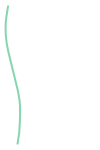

In [225]:
osmnx_line

In [227]:
original_network_test = original_network.loc[original_network.street_id==19412]
original_line = original_network_test.geometry.unique()[1]
original_network_test

,street_id,pje_ep,geometry,line_angle
231,19412.0,0.873692,"MULTILINESTRING ((336405.636 6296489.467, 3364...",85.712048
232,19412.0,0.873692,"MULTILINESTRING ((336406.029 6296494.701, 3364...",93.807716


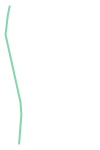

In [228]:
original_line

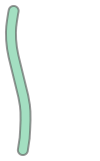

In [229]:
osmnx_buffer = osmnx_line.buffer(5)
osmnx_buffer

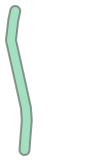

In [230]:
original_buffer = original_line.buffer(5)
original_buffer

In [235]:
original_buffer.length

313.99319222534297

In [236]:
osmnx_buffer.length

314.3500157221043

In [243]:
# Calculate percentage of overlapping in shortest line
if original_buffer.length < osmnx_buffer.length:
    overlaping_area_pct = (original_buffer.difference(osmnx_buffer).area) / (original_buffer.area)
else:
    overlaping_area_pct = (osmnx_buffer.difference(original_buffer).area) / (osmnx_buffer.area)

overlaping_area_pct

0.45250025416925566